### Import the relevant packages 

In [104]:
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.model_selection import train_test_split

### Reading the tumor MRI images 

In [105]:
tumor = []
path_to_tumor_images = glob.iglob('./data/brain_tumor_dataset/yes/*.jpg')

for file in path_to_tumor_images:
    img = cv2.imread(file)

    # resizing the image
    img = cv2.resize(img, (128, 128))

    # reordering the color channels
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])

    tumor.append(img)


print(f'Number of tumor images: {len(tumor)}')

Number of tumor images: 935


### Reading the healthy MRI images

In [106]:
no_tumor = []
path_to_no_tumor_images = glob.iglob('./data/brain_tumor_dataset/no/*.jpg')

for file in path_to_no_tumor_images:
    img = cv2.imread(file)

    # resizing the image
    img = cv2.resize(img, (128, 128))

    # reordering the color channels
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])

    no_tumor.append(img)


print(f'Number of healthy images: {len(no_tumor)}')

Number of healthy images: 886


### Converting the lists of images to numpy arrays

In [107]:
tumor = np.array(tumor)
no_tumor = np.array(no_tumor)

### Taking a look at the dimensions of the arrays

In [108]:
print(f"Shape of tumor images array: {tumor.shape}")
print(f"Number of images: {tumor.shape[0]}")
print(f"Number of channels: {tumor.shape[3]} (RGB)")
print(f"Size of each channel: {tumor.shape[1]} x {tumor.shape[2]}")

print("\n")

print(f"Shape of no tumor images array: {no_tumor.shape}")
print(f"Number of images: {no_tumor.shape[0]}")
print(f"Number of channels: {no_tumor.shape[3]} (RGB)")
print(f"Size of each channel: {no_tumor.shape[1]} x {no_tumor.shape[2]}")

Shape of tumor images array: (935, 128, 128, 3)
Number of images: 935
Number of channels: 3 (RGB)
Size of each channel: 128 x 128


Shape of no tumor images array: (886, 128, 128, 3)
Number of images: 886
Number of channels: 3 (RGB)
Size of each channel: 128 x 128


### Visualizing some of the MRI images 

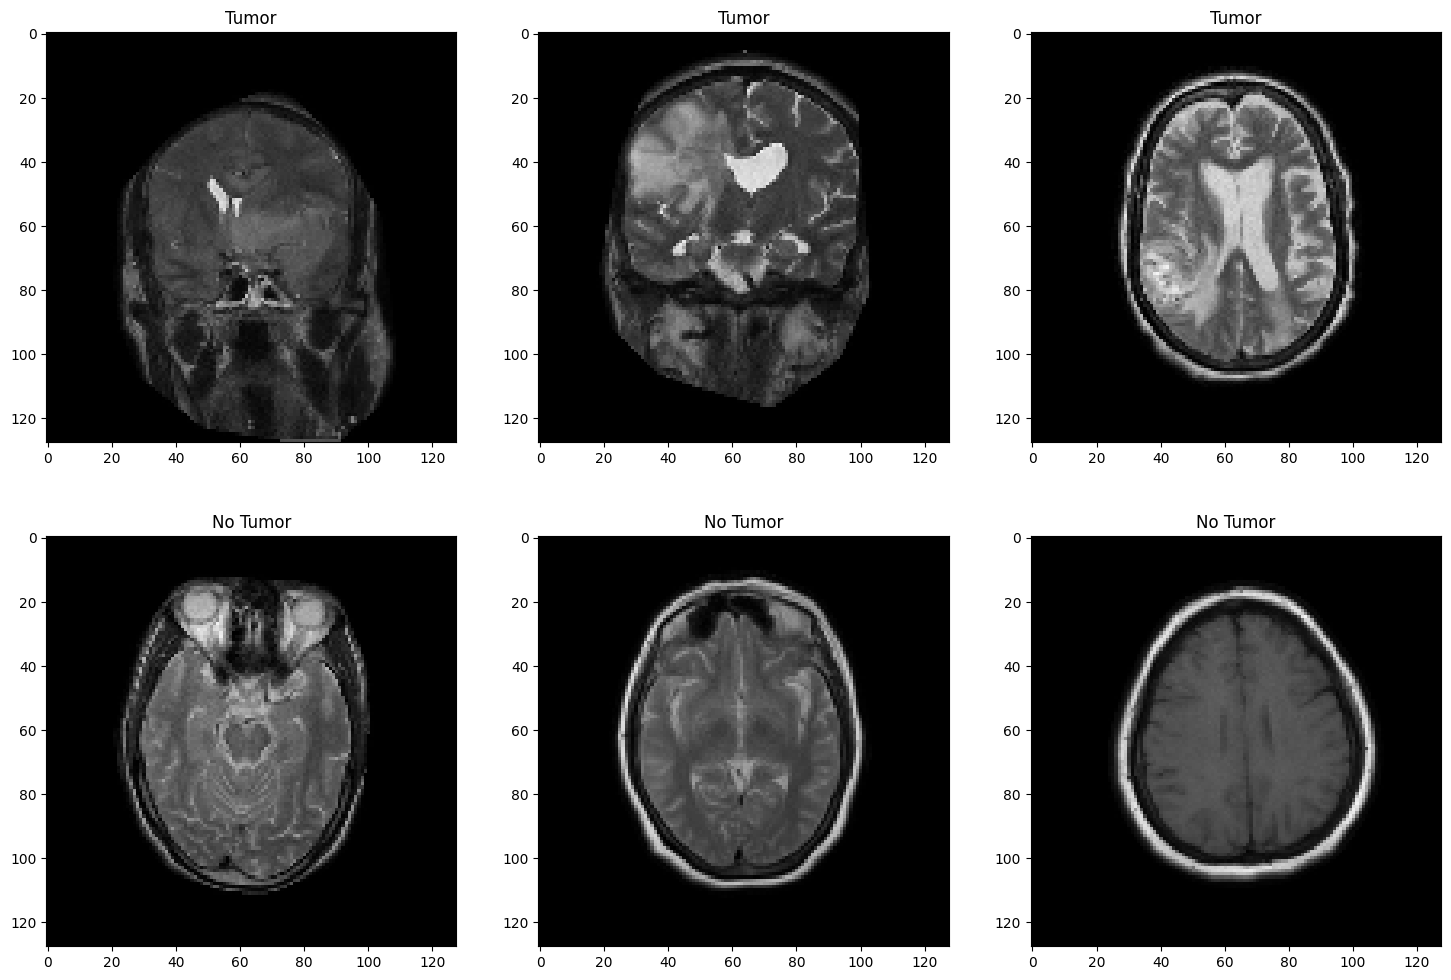

In [109]:
# initialize the plot
plt.figure(figsize=(18, 12))

for i in range(3):
    # tumor images
    plt.subplot(2, 3, i+1)
    plt.title('Tumor')
    plt.imshow(tumor[random.randint(0, len(tumor)-1)])

    # no_tumor images
    plt.subplot(2, 3, i+4)
    plt.title('No Tumor')
    plt.imshow(no_tumor[random.randint(0, len(no_tumor)-1)])

### Creating a custom pytorch Dataset class

In [110]:
class MRI(Dataset):

    def __init__(self, images, labels, train_test_val_split=True):
        """Initializes the object and splits data into train/val/test sets."""
        # Reorder images array for PyTorch convention
        images = images.reshape((images.shape[0], images.shape[3], images.shape[1], images.shape[2]))

        if train_test_val_split:
            # Split data into training and testing sets (80/20 split)
            self.images, self.images_test, self.labels, self.labels_test = train_test_split(
                images.astype(np.float32), labels, test_size=0.2, random_state=42
            )

            # Further split the training set into train and validation sets (60/20/20 split)
            self.images_train, self.images_val, self.labels_train, self.labels_val = train_test_split(
                self.images, self.labels, test_size=0.25, random_state=42
            )

        else:
            # Since train_test_val_split is False, there is no split between train/val/test
            self.images_train = images.astype(np.float32)
            self.labels_train = labels
            self.images_test = None
            self.images_val = None

        # Set default mode to "train"
        self.mode = "train"


    def __len__(self):
        """Returns the amount of images in the dataset (considering the current mode). """
        # Adjust the logic based on the current mode (train, val, or test)
        if self.mode == "train":
            return len(self.images_train)
        elif self.mode == "val" and self.images_val is not None:
            return len(self.images_val)
        elif self.mode == "test" and self.images_test is not None:
            return len(self.images_test)


    def __getitem__(self, index):
        """Returns a custom representation of the data inside the object (considering the current mode). """
        # Access data based on the current mode
        if self.mode == "train":
            image = self.images_train[index]
            label = self.labels_train[index]
        elif self.mode == "val" and self.images_val is not None:
            image = self.images_val[index]
            label = self.labels_val[index]
        elif self.mode == "test" and self.images_test is not None:
            image = self.images_test[index]
            label = self.labels_test[index]

        # Convert data to float32 and return as a dictionary
        item = {"image": image.astype(np.float32), "label": label.astype(np.float32)}
        return item


    def normalize(self):
        """Normalizes the images(optional). """
        self.images_train /= 255.0

        if self.images_val is not None:
            self.images_val /= 255.0

        if self.images_test is not None:
            self.images_test /= 255.0


    def set_mode(self, mode):
        """Sets the current mode (train, val, or test). """
        if mode not in ["train", "val", "test"]:
            raise ValueError(f"Invalid mode: {mode}")
        self.mode = mode


### Getting the data ready for the custom dataset

In [111]:
# create arrays for the labels. tumors are represented by ones, no tumors are represented by zeros
tumor_labels = np.ones(tumor.shape[0])
no_tumor_labels = np.zeros(no_tumor.shape[0])

# combine the images into one array for the dataset
combined_images = np.concatenate((tumor, no_tumor), axis=0)

# combine the labels into one array for the dataset
combined_labels = np.concatenate((tumor_labels, no_tumor_labels))

### Putting the arrays of MRI images into the custom dataset

In [112]:
# create an MRI object from the custom dataclass by giving it the images and labels
mri_dataset = MRI(images=combined_images, labels=combined_labels, train_test_val_split=True)

# execute the normalize function of the MRI class
mri_dataset.normalize()

### Defining a neural network class

In [113]:
class CNN(nn.Module):

    def __init__(self):

        # initialize the super class
        super(CNN, self).__init__()

        # define the neural network structure
        self.cnn_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=5),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=5)
        )

        # define the fully connected (fc) model structure
        self.fc_model = nn.Sequential(
            nn.Linear(in_features=256, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=1),
        )

    # define the forward propagation
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)

        return x

### Switching the device used by pytorch to the GPU of the system

In [114]:
# check if the systems graphics processing unit allows for CUDA
torch.cuda.is_available()

# get the GPU as the device for pytorch
device = torch.device('cuda:0')

# tell the model to run on the GPU
model = CNN().to(device)

### Setting hyperparameters for the model training

In [115]:
# set the learning rate
eta = 0.0001

# set the epochs / amount of passes through the entire dataset
EPOCH = 350

# choose the popular Adam algorithm as the optimization technique
optimizer = torch.optim.Adam(model.parameters(), lr=eta)

# use the DataLoader from pytorch to grab batches of 32 random images
mri_dataset.set_mode("train")
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)

# set the model to training mode
model.train()

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

### Training the model

In [116]:
# initialize the separate dataloaders
train_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

# keep track of epoch losses in order to visualize them later and make adjustments to the hyperparameters (if needed)
epoch_train_loss = []
epoch_val_loss = []

for epoch in range(1, EPOCH):

    # initialize the training losses list
    train_losses = []

    # switch the datasets mode to train
    mri_dataset.set_mode('train')

    # for each batch of 32 images and labels
    for D in train_dataloader:

        # reset gradients to zero before processing the current batch
        optimizer.zero_grad()

        # extract the images and labels and move them over to the device (GPU)
        data = D['image'].to(device)
        label = D['label'].to(device)

        # pass the data through the model to get the predictions
        y_hat = model(data)

        # define Binary Cross Entropy Loss as the loss function
        error = nn.BCELoss()

        # calculate the total loss for the batch by summing the individual losses per image
        loss = torch.sum(error(y_hat.squeeze(), label))

        # perform backpropagation to calculate gradients based on the current batch loss
        loss.backward()

        # update the model parameters using the calculated gradients and the optimizer algorithm
        optimizer.step()

        # append the current batch loss to the training losses list
        train_losses.append(loss.item())

    # append the mean of the training losses to the epoch training losses list
    epoch_train_loss.append(np.mean(train_losses))

    # initialize the validation losses list
    val_losses = []

    # switch the model to evaluation mode
    model.eval()

    # switch the datasets mode to validation
    mri_dataset.set_mode('val')

    # deactivate gradient calculation (with torch.no_grad()) as we don't update parameters during validation
    with torch.no_grad():

        # for each batch of 32 images and labels
        for D in val_dataloader:

            # extract the images and labels and move them over to the device (GPU)
            data = D['image'].to(device)
            label = D['label'].to(device)

            # pass the data through the model to get the predictions
            y_hat = model(data)

            # define Binary Cross Entropy Loss as the loss function
            error = nn.BCELoss()

            # calculate the total loss for the batch by summing the individual losses per image
            loss = torch.sum(error(y_hat.squeeze(), label))

            # append the current batch loss to the validation losses list
            val_losses.append(loss.item())

    # append the mean of the validation losses to the epoch validation losses list
    epoch_val_loss.append(np.mean(val_losses))

    # print the training epoch number and average losses every 10 epochs
    if (epoch + 1) % 10 == 0:
        print('Train Epoch: {}\tTrain Loss: {:.6f}\tVal Loss: {:.6f}'.format(
            epoch + 1, np.mean(train_losses), np.mean(val_losses)))

Train Epoch: 10	Train Loss: 0.550029	Val Loss: 0.562981
Train Epoch: 20	Train Loss: 0.488341	Val Loss: 0.500206
Train Epoch: 30	Train Loss: 0.462881	Val Loss: 0.493482
Train Epoch: 40	Train Loss: 0.438183	Val Loss: 0.487716
Train Epoch: 50	Train Loss: 0.424314	Val Loss: 0.483672
Train Epoch: 60	Train Loss: 0.384983	Val Loss: 0.474635
Train Epoch: 70	Train Loss: 0.369267	Val Loss: 0.484887
Train Epoch: 80	Train Loss: 0.354389	Val Loss: 0.454474
Train Epoch: 90	Train Loss: 0.319085	Val Loss: 0.456181
Train Epoch: 100	Train Loss: 0.297229	Val Loss: 0.444499
Train Epoch: 110	Train Loss: 0.282623	Val Loss: 0.448061
Train Epoch: 120	Train Loss: 0.255235	Val Loss: 0.440377
Train Epoch: 130	Train Loss: 0.229655	Val Loss: 0.450202
Train Epoch: 140	Train Loss: 0.221952	Val Loss: 0.436614
Train Epoch: 150	Train Loss: 0.184904	Val Loss: 0.429755
Train Epoch: 160	Train Loss: 0.173301	Val Loss: 0.442909
Train Epoch: 170	Train Loss: 0.156841	Val Loss: 0.442269
Train Epoch: 180	Train Loss: 0.152350	Va

### Evaluating the model

In [117]:
# switch the model from training mode to evaluation mode
model.eval()

# switch the datasets mode to test in order to evaluate the model on previously unseen data
mri_dataset.set_mode('test')
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

outputs = []
y_true = []

# disable gradient calculation temporarily
with torch.no_grad():

    for D in dataloader:
        # extract the images and labels and move them over to the device (GPU)
        image = D['image'].to(device)
        label = D['label'].to(device)

        # pass the data through the model to get the predictions
        y_hat = model(image)

        # store the predictions and true labels for later analysis
        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())

# concatenate the collected predictions and true labels from all batches into single NumPy array
outputs = np.concatenate(outputs, axis=0)
y_true = np.concatenate(y_true, axis=0)

### Defining a binary threshold 

In [118]:
def binary_threshold(scores, threshold=0.50, minimum=0, maximum=1.0):
    """This function takes a list of scores and applies a binary threshold to them."""

    # Convert input to a NumPy array for efficient processing
    x = np.array(list(scores))

    # Scores above/equal threshold set to maximum
    x[x >= threshold] = maximum

    # Scores below threshold set to minimum
    x[x < threshold] = minimum

    return x

## Testing the accuracy of the model on the data it was trained on

In [119]:
accuracy = accuracy_score(y_true, binary_threshold(outputs))
accuracy_in_percent = f"{accuracy * 100:.2f}%"

print(f"The accuracy of the model is {accuracy}, or about {accuracy_in_percent}.")

The accuracy of the model is 0.9260273972602739, or about 92.60%.


### Plotting a confusion matrix for the model evaluation

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

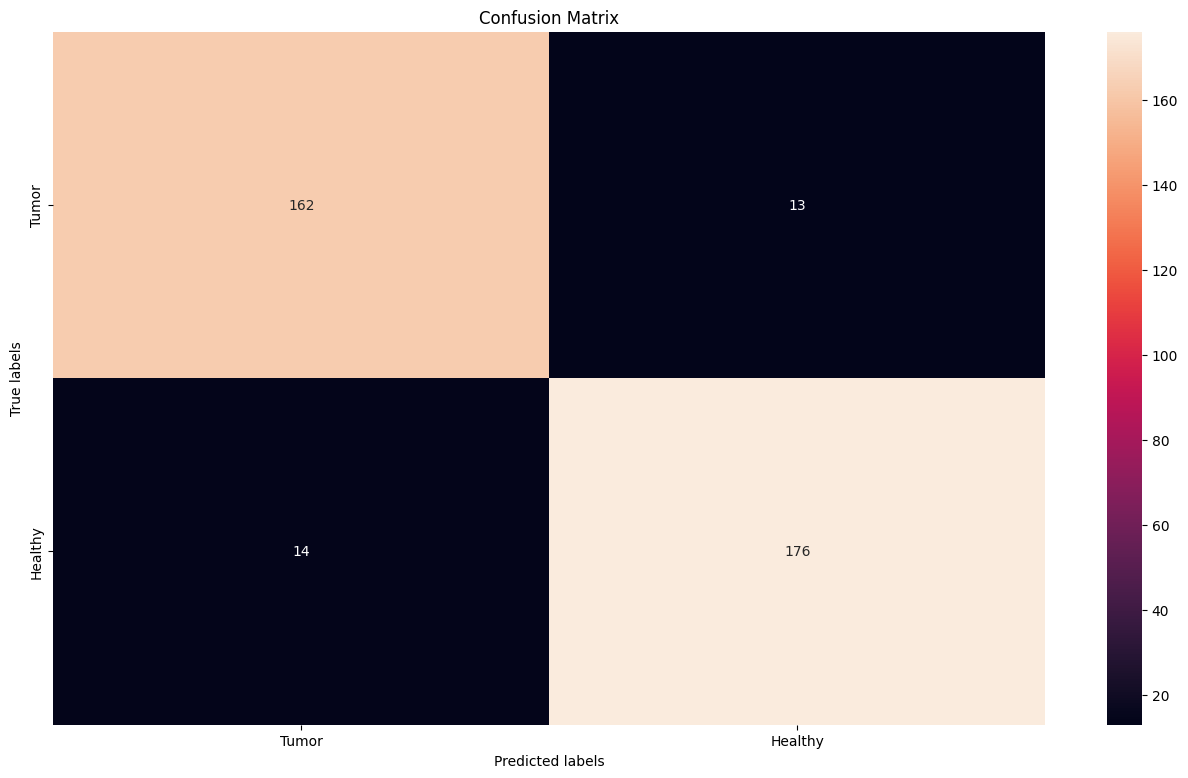

In [120]:
# create the confusion matrix
cm = confusion_matrix(y_true, binary_threshold(outputs))

# define the size of the matplotlib plot
plt.figure(figsize=(16,9))

# create a heatmap
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

# customize the labels and title
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# set tick labels for readability
ax.xaxis.set_ticklabels(['Tumor','Healthy'])
ax.yaxis.set_ticklabels(['Tumor','Healthy'])

### Visualizing the training and validation loss 


Text(0, 0.5, 'Loss')

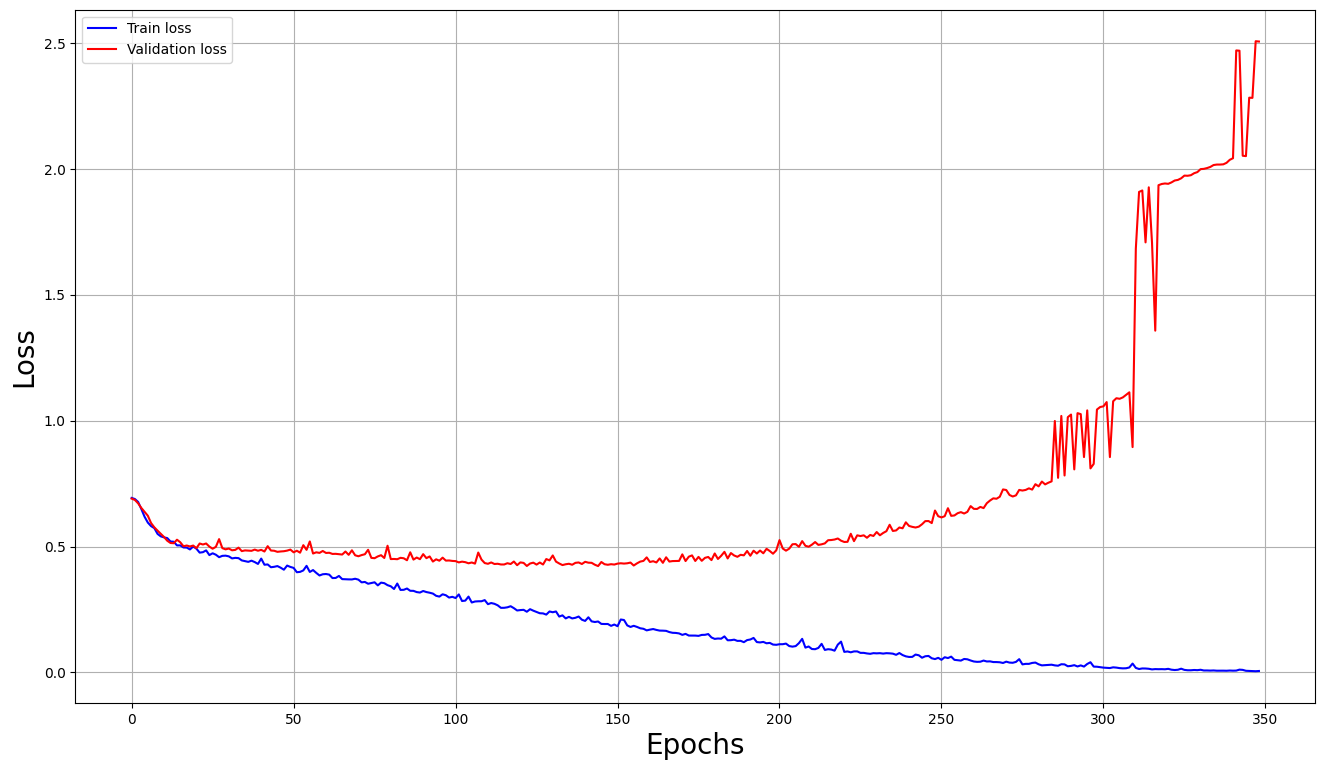

In [121]:
plt.figure(figsize=(16,9))
plt.plot(epoch_train_loss, c='b', label='Train loss')
plt.plot(epoch_val_loss, c='r', label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)

# (Optional) Testing the model with your own MRI image

In this last part, you can test the trained model with your own MRI scans.

In order to get the models predictions on your own image:
1. Put your MRI scan `.jpg` file into the `./data/test_images/predict/` directory.
2. Run the cells below (after having run all the cells above so that the model is trained and ready).

**Notes:**

- The `./data/test_images/yes/` and `./data/test_images/no/` contain one example MRI scan each. 
- Only the first `.jpg` file in the `./data/test_images/predict/` directory is used for the prediction. Therefore it is best to keep only one file in there at a time and use the `yes/` and `no/` directories for storage. 
- The output of the last cell in this notebook will show you the models prediction. 



Loaded the test tumor image: ./data/test_images/predict\example_scan_tumor_2.jpg


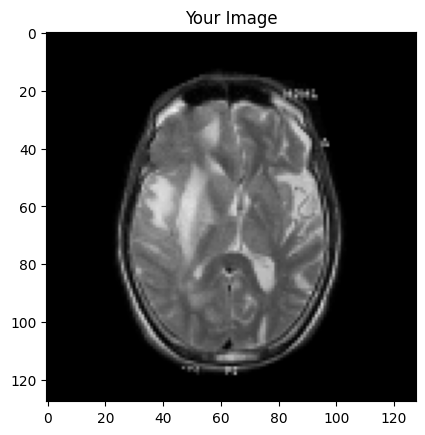

In [122]:
test_image = []
path_to_tumor_test_images = glob.iglob('./data/test_images/predict/*.jpg')

image_path = next(path_to_tumor_test_images, None)

if image_path:
  # read the image
  img = cv2.imread(image_path)

  # process the image (resizing, color channel reordering)
  img = cv2.resize(img, (128, 128))
  b, g, r = cv2.split(img)
  img = cv2.merge([r, g, b])

  test_image.append(img)

  print(f'Loaded the test tumor image: {image_path}')
else:
  print('No images found in the directory.')

# Display the first image
plt.imshow(test_image[0])
plt.title('Your Image')
plt.show()

In [123]:
# convert the test image into a numpy array
test_image = np.array(test_image)

# create a numpy array with the label for the test image (not used, but needed)
tumor_labels_test = np.ones(test_image.shape[0])

# create the new dataset
mri_dataset_test = MRI(images=test_image, labels=tumor_labels_test, train_test_val_split=False)

# execute the normalize function of the MRI class
mri_dataset_test.normalize()




# switch the model from training mode to evaluation mode
model.eval()

# put the new dataset into "train" mode, as that is where your test image is in
mri_dataset_test.set_mode('train')
dataloader_test = DataLoader(mri_dataset_test, batch_size=32, shuffle=False)

outputs_test = []
y_true_test = []


# disable gradient calculation temporarily
with torch.no_grad():

    for D in dataloader_test:
        # extract the images and labels and move them over to the device (GPU)
        image = D['image'].to(device)
        label = D['label'].to(device)

        # pass the data through the model to get the predictions
        y_hat_test = model(image)

        # store the predictions and true labels for later analysis
        outputs_test.append(y_hat_test.cpu().detach().numpy())
        y_true_test.append(label.cpu().detach().numpy())

# concatenate the collected predictions and true labels from all batches into single NumPy array
outputs_test = np.concatenate(outputs_test, axis=0)
y_true_test = np.concatenate(y_true_test, axis=0)


prediction = outputs_test[0][0]
prediction_in_percent = f"{prediction * 100:.2f}%"
print(prediction)
print(f"The model predicts that there is a {prediction_in_percent} chance of there being a tumor in the given MRI scan.")

1.0
The model predicts that there is a 100.00% chance of there being a tumor in the given MRI scan.
